In [ ]:
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os

class DhamtariDataset(Dataset):
    def __init__(self, csv_path, img_dir, normalize_weight=100, normalize_height=100):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.normalize_weight = normalize_weight
        self.normalize_height = normalize_height
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        child_id = row['child_id']

        # Find the matching image filename starting with child_id
        img_file = None
        for f in os.listdir(self.img_dir):
            if f.startswith(str(child_id)):
                img_file = f
                break

        if img_file is None:
            raise FileNotFoundError(f"No image found for child ID {child_id}")

        img_path = os.path.join(self.img_dir, img_file)

        # Load image and preprocess
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('float32') / 255.0
        img = self.to_tensor(img)

        # Normalize weight and height (optional, depends on your model)
        weight = torch.tensor([row['weight in grams'] / self.normalize_weight], dtype=torch.float32)
        height = torch.tensor([row['height in cm'] / self.normalize_height], dtype=torch.float32)

        return {
            'img': img,
            'weight': weight,
            'height': height,
            'child_id': child_id
        }


In [ ]:
import os
import pandas as pd

# Paths
image_folder = '/content'       # Your image folder path
csv_path = '/content/labels.csv'       # Your CSV path

# Load CSV, assuming it has a 'child_id' column (adjust column name if needed)
df = pd.read_csv(csv_path)
df.set_index('child_id', inplace=True)  # Index by child_id for quick lookup

matched_samples = []

# List image files
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for img_file in image_files:
    child_id = "c"+img_file[1:9]
    if child_id in df.index:
        # Get row for this child_id
        row = df.loc[child_id]
        # Extract labels (adjust column names)
        height = row['height in cm']
        weight = row['weight in grams']
        img_path = os.path.join(image_folder, img_file)

        matched_samples.append({
            'img_path': img_path,
            'child_id': child_id,
            'height': height,
            'weight': weight
        })
    else:
        print(f"Warning: No CSV entry for image {img_file} (child_id={child_id})")

print(f"Total matched samples: {len(matched_samples)}")


Total matched samples: 102


In [ ]:
matched_samples

[{'img_path': '/content/child0049_child0049_01.jpg',
  'child_id': 'child0049',
  'height': np.float64(101.0),
  'weight': np.int64(15700)},
 {'img_path': '/content/Child0076_child0076_01.jpg',
  'child_id': 'child0076',
  'height': np.float64(103.0),
  'weight': np.int64(18500)},
 {'img_path': '/content/child0003_child0003_01.jpg',
  'child_id': 'child0003',
  'height': np.float64(95.7),
  'weight': np.int64(19000)},
 {'img_path': '/content/Child0079_child0079_01.jpg',
  'child_id': 'child0079',
  'height': np.float64(122.0),
  'weight': np.int64(21000)},
 {'img_path': '/content/Child0073_child0073_01.jpg',
  'child_id': 'child0073',
  'height': np.float64(120.0),
  'weight': np.int64(21400)},
 {'img_path': '/content/Child0093_child0093_01.jpg',
  'child_id': 'child0093',
  'height': np.float64(103.0),
  'weight': np.int64(15000)},
 {'img_path': '/content/Child0071_child0071_01.jpg',
  'child_id': 'child0071',
  'height': np.float64(112.0),
  'weight': np.int64(20000)},
 {'img_path': 

In [ ]:
import os
import json
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- Step 1: Your matched samples list (example) ---
# Assume you have a list of dicts: matched_samples = [{'img_path': ..., 'child_id': ..., 'height': ..., 'weight': ...}, ...]

# For demonstration, replace this with your actual matched_samples list
# matched_samples = [...]

# --- Step 2: Dataset class mimicking repo ---

class DhamtariDataset(Dataset):
    def __init__(self, samples, image_size=(128,128), normalize_height=100, normalize_weight=100):
        self.samples = samples
        self.image_size = image_size
        self.normalize_height = normalize_height
        self.normalize_weight = normalize_weight
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = sample['img_path']
        height = sample['height']
        weight = sample['weight']

        # Load image in RGB
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('float32')
        # Resize
        img = cv2.resize(img, self.image_size)
        # Normalize to [0,1]
        img /= 255.0
        # Convert to tensor (C x H x W)
        img_tensor = self.to_tensor(img)

        # Create dummy mask (2 channels) and joint heatmap (1 channel here as placeholder)
        mask = torch.zeros((2, self.image_size[1], self.image_size[0]), dtype=torch.float32)
        joint = torch.zeros((1, self.image_size[1], self.image_size[0]), dtype=torch.long)

        # Normalize labels as in repo
        height_tensor = torch.tensor([height / self.normalize_height], dtype=torch.float32)
        weight_tensor = torch.tensor([weight / self.normalize_weight], dtype=torch.float32)

        return {
            'img': img_tensor,
            'mask': mask,
            'joint': joint,
            'height': height_tensor,
            'weight': weight_tensor,
            'child_id': sample['child_id']
        }

# --- Step 3: DataLoader setup ---

def collate_fn(batch):
    # Custom collate to stack tensors and collect child_ids
    imgs = torch.stack([item['img'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    joints = torch.stack([item['joint'] for item in batch])
    heights = torch.stack([item['height'] for item in batch])
    weights = torch.stack([item['weight'] for item in batch])
    child_ids = [item['child_id'] for item in batch]
    return imgs, masks, joints, heights, weights, child_ids

# Use your actual matched_samples list here
dataset = DhamtariDataset(matched_samples)
loader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# --- Step 4 & 5: Iterate and save all data ---

all_imgs = []
all_masks = []
all_joints = []
all_heights = []
all_weights = []
all_ids = []

for imgs, masks, joints, heights, weights, child_ids in loader:
    all_imgs.append(imgs)
    all_masks.append(masks)
    all_joints.append(joints)
    all_heights.append(heights)
    all_weights.append(weights)
    all_ids.extend(child_ids)

all_imgs = torch.cat(all_imgs)
all_masks = torch.cat(all_masks)
all_joints = torch.cat(all_joints)
all_heights = torch.cat(all_heights)
all_weights = torch.cat(all_weights)

# Save tensors
torch.save(all_imgs, '/content/dhamtari_images.pt')
torch.save(all_masks, '/content/dhamtari_masks.pt')
torch.save(all_joints, '/content/dhamtari_joints.pt')
torch.save(all_heights, '/content/dhamtari_heights.pt')
torch.save(all_weights, '/content/dhamtari_weights.pt')

# Save metadata
with open('/content/dhamtari_child_ids.json', 'w') as f:
    json.dump(all_ids, f)

print("Preprocessing complete. Files saved in /content/")

# --- Step 6: Download files from Colab ---


Preprocessing complete. Files saved in /content/


In [ ]:

from google.colab import files

files.download('/content/dhamtari_images.pt')
files.download('/content/dhamtari_masks.pt')
files.download('/content/dhamtari_joints.pt')
files.download('/content/dhamtari_heights.pt')
files.download('/content/dhamtari_weights.pt')
files.download('/content/dhamtari_child_ids.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
data = torch.load('dhamtari_images.pt')
print(data.shape)


torch.Size([102, 3, 128, 128])


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_skeleton(img_tensor, joint_heatmaps, skeleton_pairs=None):
    # Convert image tensor to numpy
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # H, W, C
    img = (img * 255).astype(np.uint8).copy()

    # Get joint keypoints from heatmaps
    joints = []
    for i in range(joint_heatmaps.shape[0]):
        heatmap = joint_heatmaps[i].cpu().numpy()
        y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        joints.append((x, y))

    # Draw joints
    for (x, y) in joints:
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

    # Draw skeleton connections if pairs given
    if skeleton_pairs:
        for (j1, j2) in skeleton_pairs:
            pt1 = joints[j1]
            pt2 = joints[j2]
            cv2.line(img, pt1, pt2, (255, 0, 0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage:
# img_tensor: a [3, H, W] image tensor
# joint_heatmaps: a [19, H, W] tensor from your dataset sample
# skeleton_pairs: list of tuples with connected joint indices, e.g. [(0,1), (1,2), ...]


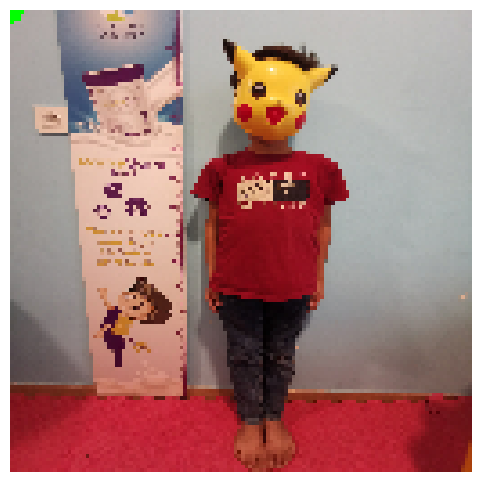

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_sample(sample, skeleton_pairs=None):
    # sample is a dict: {'img': tensor, 'joint': tensor, ...}
    img_tensor = sample['img']  # [3, H, W]
    joint_heatmaps = sample['joint']  # [num_joints, H, W]

    # Convert image tensor to numpy (H, W, C) uint8
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # H, W, C
    img = (img * 255).astype(np.uint8).copy()

    # Get joint points by finding max location in each heatmap
    joints = []
    for i in range(joint_heatmaps.shape[0]):
        heatmap = joint_heatmaps[i].cpu().numpy()
        y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        joints.append((x, y))

    # Draw joints on image
    for (x, y) in joints:
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

    # Draw skeleton lines if pairs are provided
    if skeleton_pairs:
        for (j1, j2) in skeleton_pairs:
            pt1 = joints[j1]
            pt2 = joints[j2]
            cv2.line(img, pt1, pt2, (255, 0, 0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage:

# Assuming 'dataset' is your PyTorch Dataset (DhamtariDataset or similar)
sample = dataset[4]  # get first sample

# Define your skeleton joint connections as pairs of indices, example:
# skeleton_pairs = [(0,1), (1,2), (2,3), ...]  # Replace with your actual joint connections
skeleton_pairs = None  # or define if you have

visualize_sample(sample, skeleton_pairs)


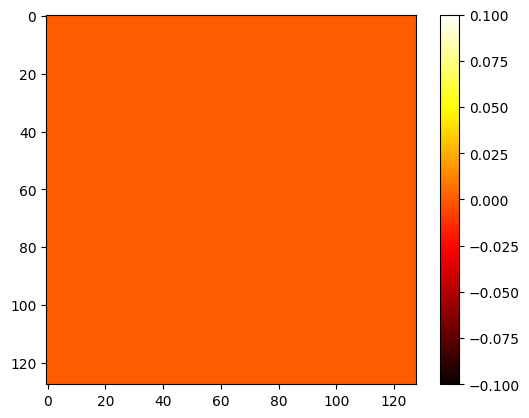

In [ ]:
import matplotlib.pyplot as plt
joint_heatmaps = sample['joint'].cpu().numpy()
plt.imshow(joint_heatmaps[0], cmap='hot')
plt.colorbar()
plt.show()


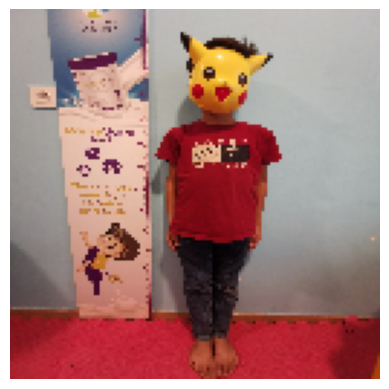

In [ ]:
img = sample['img'].permute(1,2,0).cpu().numpy()
img = (img * 255).astype(np.uint8)
plt.imshow(img)
plt.axis('off')
plt.show()


TypeError: Invalid shape (2, 128, 128) for image data

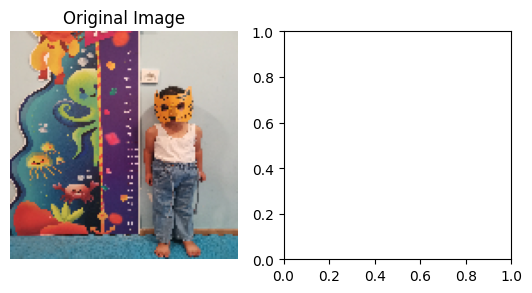

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load the preprocessed tensors
images = torch.load("/content/dhamtari_images.pt")  # shape: (N, C, H, W)
masks = torch.load("/content/dhamtari_masks.pt")    # shape: (N, 1, H, W)

# Pick an index to visualize
idx = 0  # change to see different samples
image = images[idx]  # shape: (C, H, W)
mask = masks[idx]    # shape: (1, H, W)

# Convert to numpy for plotting
image_np = image.permute(1, 2, 0).numpy()  # (H, W, C)
mask_np = mask.squeeze().numpy()           # (H, W)

# Visualize side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image_np)
plt.imshow(mask_np, cmap='Reds', alpha=0.5)  # overlay mask in red
plt.title("Image + Mask Overlay")
plt.axis("off")

plt.show()


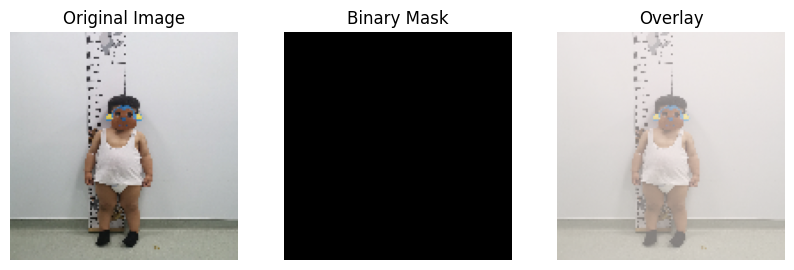

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load data
images = torch.load("/content/dhamtari_images.pt")  # (N, C, H, W)
masks = torch.load("/content/dhamtari_masks.pt")    # (N, 2, H, W)

# Pick index
idx = 2
image = images[idx]  # (C, H, W)
mask = masks[idx]    # (2, H, W)

# Convert from probability map to binary mask
mask_class = mask.argmax(dim=0)  # (H, W) with values 0 or 1

# Convert to numpy
image_np = image.permute(1, 2, 0).numpy()
mask_np = mask_class.numpy()

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Binary Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image_np)
plt.imshow(mask_np, cmap='Reds', alpha=0.5)
plt.title("Overlay")
plt.axis("off")

plt.show()


In [ ]:
for idx in range(len(masks)):
    mask = masks[idx]
    mask_class = mask.argmax(dim=0)
    if mask_class.unique().numel() > 1:  # Found a non-empty mask
        print("Found foreground at index:", idx)
        break


In [ ]:
print(mask.shape)            # Should be (2, H, W)
print(mask.min(), mask.max())  # Range of values
print(mask_class.unique())     # Classes present after argmax


torch.Size([2, 128, 128])
tensor(0.) tensor(0.)
tensor([0])


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 116MB/s]


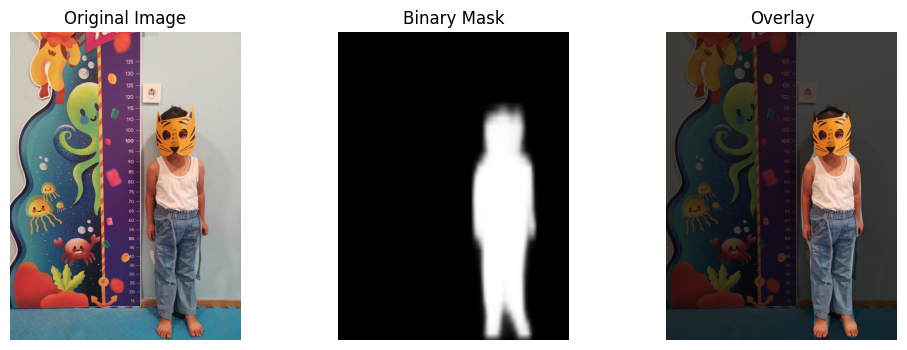

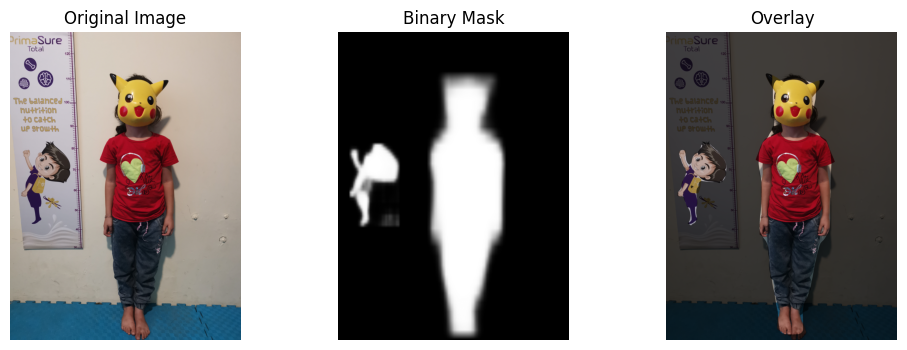

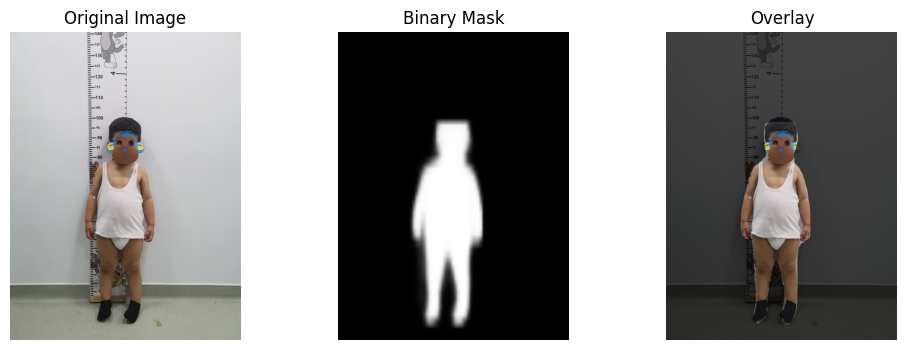

In [ ]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Use pretrained Mask R-CNN for person segmentation
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

# Transformation for the images
transform = transforms.Compose([
    transforms.ToTensor()
])

# Function to get mask for "person" class
def get_person_mask(img_tensor):
    with torch.no_grad():
        predictions = model([img_tensor])[0]
    masks = predictions['masks']  # [N, 1, H, W]
    labels = predictions['labels']  # COCO classes
    scores = predictions['scores']

    # Keep only person (label==1 in COCO) with high score
    person_masks = []
    for mask, label, score in zip(masks, labels, scores):
        if label == 1 and score > 0.8:
            person_masks.append(mask[0].cpu().numpy())

    if person_masks:
        combined_mask = np.clip(np.sum(person_masks, axis=0), 0, 1)
        return combined_mask
    else:
        return np.zeros((img_tensor.shape[1], img_tensor.shape[2]))

# Path to test image folder (change to your path)
image_folder = "/content"  # replace with your image path
test_images = [f for f in os.listdir(image_folder) if f.lower().endswith(('jpg', 'png'))]

# Run on first few images
for img_name in test_images[:3]:
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)

    mask = get_person_mask(img_tensor)

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Binary Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    overlay = np.array(img).astype(float) / 255
    overlay[mask < 0.5] *= 0.3  # dim background
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()
